# Data Pre-Processing with SAS WorkBench
This notebook is meant to be viewed after the Data Exploration notebook and is a continuation of said exploration. In this notebook we will address some of the issues we've identified in our data exploration of ML model development. The steps shown here will be implemented via pipelines in the machine learning notebook.

We will perform the following tasks:
- Removing columns with large missingness
- Data Partitioning
- Imputation
- Rare Event Handling
- Variable Encoding
- Variable Scaling
- Feature Creation
- Feature Selection

## Imports
In the next section we will import the necessary packages and modules that will be used throughout this project.

In [53]:
# Import necessary packages and modules

import matplotlib.pyplot as plt
from math import ceil
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE, SelectFromModel, VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Import the dataset
churn_df = pd.read_csv('../data/output/customer_churn_abt.csv',header='infer')

## Removing Columns
Remove columns that have no predictive power, strongly correlated columns, as well as columns involved in computing composite columns.

In [55]:
# Drop columns in place
# churn_df.drop(labels=["ID","birthDate","avgDiscountValue12","intAdExposureCountAll"],axis=1,inplace=True)
churn_df.drop(labels=["birthDate","avgDiscountValue12","intAdExposureCountAll"],axis=1,inplace=True)

In [56]:
# Drop columns with over 50% missing values. Drops Text and Review_Title columns
threshold = 0.5 *churn_df.shape[0]
churn_df = churn_df.dropna(thresh=threshold, axis= 1)

## Column Names
Over the ext few code cells new variables will be created to quickly reference columns belonging to a given group based on type, missingness, etc.

In [57]:
# Creates lists representing the input variables and target

inputs = [_input for _input in churn_df.columns if _input not in ["LostCustomer"]]
numerics = [_input for _input in churn_df.select_dtypes(["int","float"]).columns if _input not in ["LostCustomer"]]
categoricals = [_input for _input in churn_df.select_dtypes("object").columns]
target="LostCustomer"

In [58]:
# Compute skeweness and kurtosis for all numeric variables

skeweness=churn_df.select_dtypes(['int','float']).skew()[2:]
kurtosis=churn_df.select_dtypes(['int','float']).kurtosis()[2:]

# Selecting highly non-normal columns
high_skeweness=skeweness[(skeweness>3)|(skeweness< -3)]
high_kurtosis=kurtosis[(kurtosis>3)|(kurtosis< -3)]

# Create a list of skeweness columns
skewed_cols = [col for col in high_skeweness.index if col in high_kurtosis]


In [59]:
# Display the proportion of missing values
missing=churn_df.isna().sum()
missing=missing[missing>0]/churn_df.shape[0]
missing_list=missing.index.to_list()

## Data Partitioning
Partitions the data into stratified training and testing partitions using 80/20 split

In [60]:
# Partitions data into training and validation

x_train,x_test,y_train,y_test = train_test_split(churn_df[inputs],churn_df[target],test_size=0.2,stratify=churn_df[target], random_state=42)

In [61]:
# Display the shapes of the partitions
print(f"The training partition inputs have dimensions: {x_train.shape} and the targets have dimension {y_train.shape}")
print(f"The validation partition inputs have dimensions: {x_test.shape} and the targets have dimension {y_test.shape}")

The training partition inputs have dimensions: (4000, 24) and the targets have dimension (4000,)
The validation partition inputs have dimensions: (1000, 24) and the targets have dimension (1000,)


In [62]:
# Verify the target distributions are close to one another
y_train_dist = y_train.value_counts(normalize=True)
y_test_dist = y_test.value_counts(normalize=True)

print(f"The difference in the target distribution proportion between both partitions is:",end="\n\n")
print(f"{y_train_dist-y_test_dist}")

The difference in the target distribution proportion between both partitions is:

LostCustomer
0    0.00025
1   -0.00025
Name: proportion, dtype: float64


## Imputation
Imputes missing values with the median given the distribution of the columns with misingness.

In [63]:
# Create, fit and apply a simple imputer

median_imputer = SimpleImputer(strategy="median")
median_imputer =median_imputer.fit(x_train[numerics])
x_train[numerics] = median_imputer.transform(x_train[numerics])

In [64]:
# Imputes missing value in the testing partition
x_test[numerics] = median_imputer.transform(x_test[numerics])

In [65]:
# Displays the number of missing values in all the listed columns
median_imputer.statistics_

array([3.1000e+01, 1.0000e+00, 1.8000e+01, 3.0000e+00, 7.5000e+01,
       7.5000e+01, 6.2275e+01, 1.3000e+01, 3.1000e+01, 6.0000e+00,
       1.2000e+01, 1.8000e+01, 7.0000e+00, 2.0000e+00, 7.0416e+02,
       8.7000e+01, 8.4000e+04, 9.3080e+04, 4.0000e+00, 2.5000e+01,
       6.2500e+00])

## Addressing Rare Observations
Addressing outliers in columns with high skeweness and kurtosis

In [66]:
# Apply a log transformation to the skewed columns
log_cols = ["LOG" + col for col in skewed_cols]
x_train[log_cols] = x_train[skewed_cols].transform(np.log1p)

# Apply log transformation to the validation partition
x_test[log_cols] = x_test[skewed_cols].transform(np.log1p)

print('-------------------NEW SKEWENESS-------------------',end='\n\n')
print(x_train[log_cols].skew(), end='\n\n')

print('-------------------NEW KURTOSIS-------------------',end='\n\n')
print(x_train[log_cols].kurtosis())

-------------------NEW SKEWENESS-------------------

LOGLastPurchaseAmount       -2.418797
LOGAvgPurchaseAmount12      -2.969597
LOGAvgPurchaseAmountTotal    0.582513
LOGcustomersales             1.100048
LOGAvgPurchasePerAd12       -0.658404
dtype: float64

-------------------NEW KURTOSIS-------------------

LOGLastPurchaseAmount        15.252326
LOGAvgPurchaseAmount12       12.910452
LOGAvgPurchaseAmountTotal     2.832499
LOGcustomersales              4.599611
LOGAvgPurchasePerAd12         1.780120
dtype: float64


In [67]:
# Define a function to compare the distributions before and after they are log transformed

def hist_compare(data:pd.DataFrame, before_cols: list, after_cols: list, figsize: tuple=(10,10), fig_per_row:int=2):
    
    # Displaybefore and after density curves for each column in both lists
    
    # Parameters
    # ----------------
    # data: pd.DataFrame
    #     Pandas datafrme containing data that will be visualized
    # before_cols: list
    #     List contining the names of the column to be visualized
    #     Length must match dimension of cols2
    # after_cols: list
    #     List contining the names of the column to be visualized
    #     Length must match dimension of cols1
    # figsize: tuple
    #     Dimensions of the plot grid that will be generated
    # fig_per_row: int
    #     How many figures a user wants per row. Default = 2

    # Ensure the shape of the input lists are the same
    if len(before_cols)!=len(after_cols):
        raise ValueError(f"The length of the column lists are different dimensions. cols1: {len(before_cols)}, cols2: {len(after_cols)}")
    
    # Determine plot dimensions
    if len(before_cols)+len(after_cols)<fig_per_row:
        nrows,ncols=1, fig_per_row
    else:
        nrows,ncols = ceil(len(before_cols)+len(after_cols) / fig_per_row), fig_per_row
    
    # Create subplots based on specified dimensions
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = axs.flatten()

    # Create a dictionary of the column to be displayed and their corresponding axes

    axs_dict ={}
    cols1_idx =0
    cols2_idx =0
    for ax_idx in range(len(axs)):
        if ax_idx%2==0:
            axs_dict.update({ax_idx:before_cols[cols1_idx]})
            cols1_idx=1
        else:
            axs_dict.update({ax_idx:after_cols[cols2_idx]})
            cols2_idx=1

    # Iterate through the columns and the created axes
    for ax_idx,col in axs_dict.items():
        # Transformed columns will be displayed in orange, non-transformed columns will be blue.
        if ax_idx%2==0:
            color="blue"
        else:
            color="orange"
        
        # Create density plot
        sns.kdeplot(data=data, x=col,ax=axs[ax_idx],color=color)
        axs[ax_idx].set_title(f"{col} Density Plot")

    # Ensure there is no overlap between plots
    plt.tight_layout()

    return fig
    


/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

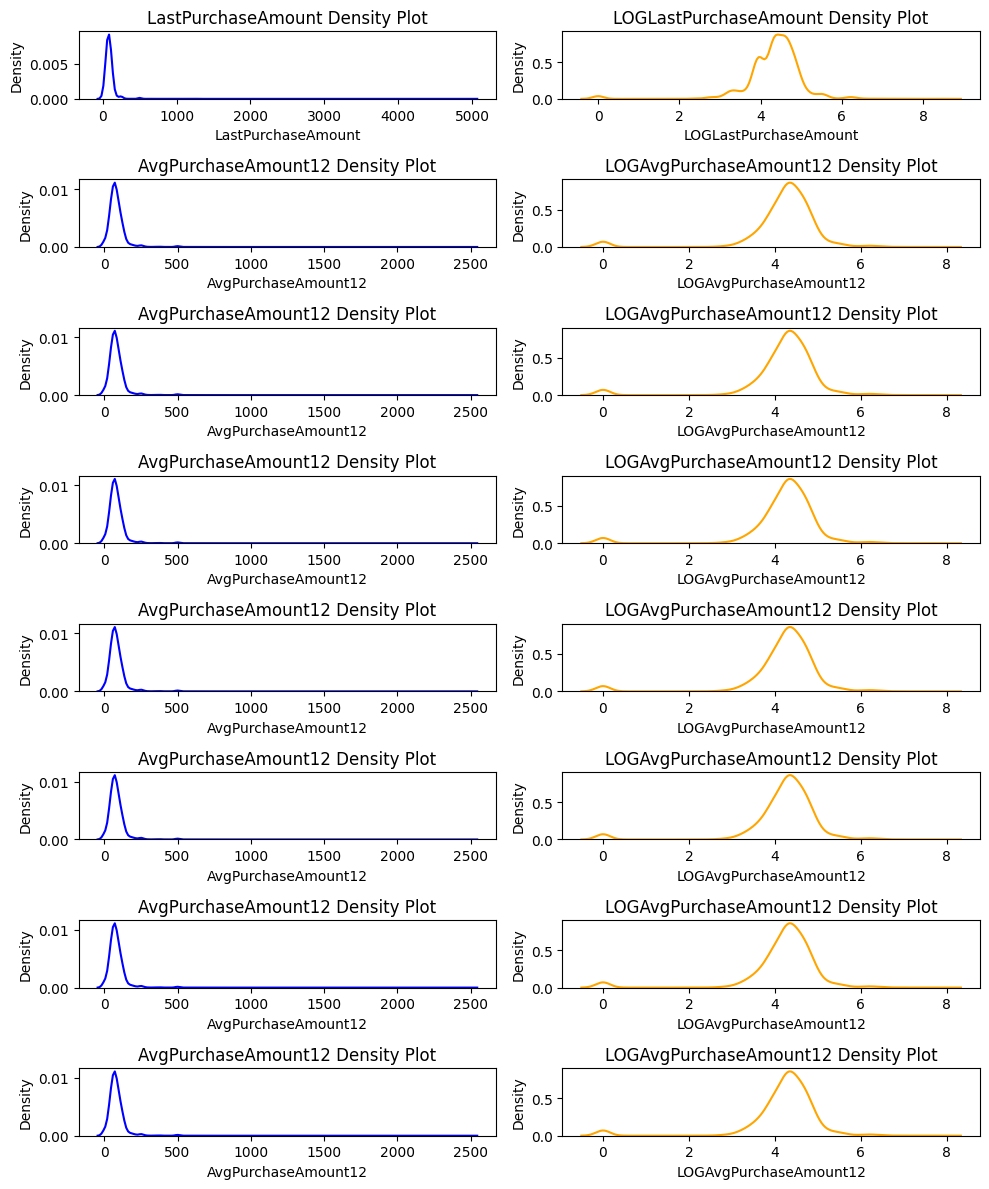

In [68]:
# Plot the difference between the distribution of the variables pre and post log transformation
transform_summary=hist_compare(x_train, skewed_cols, log_cols, figsize=(10,12))

In [69]:
# Updates the input list to include only log transformed columns
inputs = [col for col in inputs if col not in skewed_cols]+log_cols
numerics = [col for col in inputs if col not in skewed_cols]+log_cols

## One-Hot Encoding
One-Hot encodes the categorical column values.

In [70]:
# Fits the one hot encoder using the categorical columns
ohe = OneHotEncoder(drop="if_binary").fit(x_train[categoricals])

# Transform both partitions
ohe_train = ohe.transform(x_train[categoricals]).toarray()
ohe_test = ohe.transform(x_test[categoricals]).toarray()

# Add the new features to the partitions
ohe_features = ohe.get_feature_names_out()
x_train[ohe_features]=ohe_train
x_test[ohe_features]=ohe_test

In [71]:
# Drop non-OHE columns
x_train=x_train.drop(categoricals,axis=1)
x_test=x_test.drop(categoricals,axis=1)

# Update the inputs and categoricals list
inputs =[col for col in inputs if col not in categoricals]+ohe_features.tolist()
categoricals=ohe_features.tolist()

In [72]:
# Display sample of output
x_train[categoricals].head()

,DemHomeOwner_Unknown,customerGender_F,customerGender_M,customerGender_U,customerSubscrStat_Gold,customerSubscrStat_Member,customerSubscrStat_Platinum
2177,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2828,0.0,0.0,1.0,0.0,0.0,0.0,1.0
829,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4328,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2216,1.0,1.0,0.0,0.0,0.0,0.0,1.0


## Variable scaling
Scales the numeric columns based on the distribution.

In [73]:
# Standardizes the numeric columns so they have a similar scale
standardizer = StandardScaler()
standardizer = standardizer.fit(x_train[numerics])

KeyError: "['DemHomeOwner', 'customerGender', 'customerSubscrStat'] not in index"

In [74]:
# Apply the scaler to the training validation
x_train[numerics]=standardizer.transform(x_train[numerics])
x_test[numerics]=standardizer.transform(x_test[numerics])

# Display the distribution of the numeric variables
x_train[numerics].describe().T

KeyError: "['DemHomeOwner', 'customerGender', 'customerSubscrStat'] not in index"

## Feature Selection
Performs supervised and unsupervised feature selection. Unsupercised feature selection technique used is variance thereshold. Supervised feature selection technique used are lasso selection and a decision tree selector.

In [75]:
# Unsupervised Variable Selection - Variance Thereshold
variance_selector=VarianceThreshold(threshold=0.1)
variance_selector=variance_selector.fit(x_train[inputs])
variance_features=variance_selector.get_feature_names_out()

In [76]:
# Backwards Eliminated Variable Selection
rfe_selector = RFE(estimator=LogisticRegressionCV(cv=10))
rfe_selector=rfe_selector.fit(x_train[inputs],y_train)
rfe_features=rfe_selector.get_feature_names_out()

/usr/local/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib64/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

KeyboardInterrupt: 

In [49]:
# Dtree Variable Selection
tree_selector=SelectFromModel(estimator= DecisionTreeClassifier(random_state=42))
tree_selector=tree_selector.fit(x_train[inputs],y_train)
tree_features=tree_selector.get_feature_names_out()

In [ ]:
# Display the removed features
rm_variance_features=[col for col in variance_selector.feature_names_in_ if col not in variance_features]
rm_rfe_features=[col for col in rfe_selector.feature_names_in_ if col not in rfe_features]
rm_tree_features=[col for col in tree_selector.feature_names_in_ if col not in tree_features]

print("Variance Thereshold Removed Features:", end="\n\n")
print(rm_variance_features,end="\n\n")

print("RFE Removed Features:", end="\n\n")
print(rm_rfe_features,end="\n\n")

print("Decision Tree Removed Features:", end="\n\n")
print(rm_tree_features,end="\n\n")

In [ ]:
# Select the features the tree used in both partitions
selected_features = [col for col in inputs if (col in variance_features) or (col in rfe_features) or (col in tree_features)]
selected_features